<a href="https://colab.research.google.com/github/BrendanGramp/UMDAOSC650/blob/main/autoencodermodified2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import keras
from keras import layers

In [2]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

In [3]:
! wget https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc

--2024-04-09 16:34:34--  https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109400556 (104M) [application/octet-stream]
Saving to: ‘current_SP3hourly_20110427.nc’

current_SP3hourly_2 100%[===================>] 104.33M  1.61MB/s    in 68s     

2024-04-09 16:35:43 (1.53 MB/s) - ‘current_SP3hourly_20110427.nc’ saved [109400556/109400556]



In [4]:
# import dataset (netcdf)
ds = xr.open_dataset('current_SP3hourly_20110427.nc')

In [5]:
ds

<xarray.Dataset>
Dimensions:      (starttime: 2224, y: 32, x: 32)
Coordinates:
  * starttime    (starttime) float64 9.264e+04 9.264e+04 ... 9.266e+04 9.266e+04
    endtime      (starttime) float64 ...
    x_speed      (starttime) int64 ...
    y_speed      (starttime) int64 ...
Dimensions without coordinates: y, x
Data variables:
    uh25_grid    (starttime, y, x) float32 ...
    uh03_grid    (starttime, y, x) float32 ...
    ctt_grid     (starttime, y, x) float32 ...
    dbz_grid     (starttime, y, x) float32 ...
    mask         (starttime, y, x) int64 ...
    row_indices  (starttime, y, x) int64 ...
    col_indices  (starttime, y, x) int64 ...
    lats         (starttime, y, x) float32 ...
    lons         (starttime, y, x) float32 ...

## ANN Autoencoder

We will again use the previous data, but this time we will focus on reconstructing one input variable (feature).

In [6]:
# selecting a variable
ds['dbz_grid']

<xarray.DataArray 'dbz_grid' (starttime: 2224, y: 32, x: 32)>
[2277376 values with dtype=float32]
Coordinates:
  * starttime  (starttime) float64 9.264e+04 9.264e+04 ... 9.266e+04 9.266e+04
    endtime    (starttime) float64 ...
    x_speed    (starttime) int64 ...
    y_speed    (starttime) int64 ...
Dimensions without coordinates: y, x

In [7]:
# reshape data to be samples, features
features_data = ds['dbz_grid'].stack(new_dim=(["y", "x"])).values
print(features_data.shape)

(2224, 1024)


In [8]:
features_data

array([[-35.      , -35.      , -35.      , ...,  13.949479,  12.911252,
         10.474219],
       [-35.      , -35.      , -35.      , ...,  15.252525,   9.551773,
        -12.005707],
       [-35.      , -35.      , -35.      , ..., -35.      , -35.      ,
        -35.      ],
       ...,
       [-29.150763, -33.773006, -35.      , ..., -12.28549 , -21.292902,
        -30.720982],
       [ 24.57368 ,  13.765106,  14.084679, ...,  29.180717,  28.653072,
         28.988672],
       [ 13.142024,  16.35466 ,  17.247124, ...,  25.714262,  23.523518,
         26.171114]], dtype=float32)

In [9]:
# split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    features_data,
    features_data,
    test_size=0.3,
    shuffle=False,
    random_state=42)

In [10]:
# now rescale your data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) # input
X_test = scaler.transform(X_test) # input
y_train = scaler.transform(y_train) # label
y_test = scaler.transform(y_test) # label

In [11]:
# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1556, 1024) (668, 1024) (1556, 1024) (668, 1024)


In [37]:
# create fully connected autoencoder
model = keras.Sequential()

# input
model.add(keras.Input(shape=(1024))) # features

# encoder
# hidden layers
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(8, activation="relu"))

# desired dimensions
model.add(layers.Dense(4, activation="relu"))

# decoder
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(32, activation="relu"))

# Finally, we add last layer
model.add(layers.Dense(1024, activation='linear')) # back to the original shape

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                32800     
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
 dense_8 (Dense)             (None, 4)                 36        
                                                                 
 dense_9 (Dense)             (None, 8)                 40        
                                                                 
 dense_10 (Dense)            (None, 32)                288       
                                                                 
 dense_11 (Dense)            (None, 1024)              33792     
                                                                 
Total params: 67220 (262.58 KB)
Trainable params: 6722

In [38]:
# define list of metrics
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
    keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
    keras.metrics.MeanAbsolutePercentageError(name='mean_absolute_percentage_error'),
    keras.metrics.R2Score()
]

# compile your nn
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

# set hyperparameters
BATCH_SIZE = 32
EPOCHS = 50

In [39]:
# train the NN now
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/50
44/44 [==============================] - 6s 31ms/step - loss: 0.8038 - mean_squared_error: 0.8038 - root_mean_squared_error: 0.8966 - mean_absolute_error: 0.7135 - mean_absolute_percentage_error: 1452.4873 - r2_score: 0.1908 - val_loss: 0.6727 - val_mean_squared_error: 0.6727 - val_root_mean_squared_error: 0.8202 - val_mean_absolute_error: 0.6562 - val_mean_absolute_percentage_error: 293.2098 - val_r2_score: 0.3559
Epoch 2/50
44/44 [==============================] - 1s 12ms/step - loss: 0.5503 - mean_squared_error: 0.5503 - root_mean_squared_error: 0.7418 - mean_absolute_error: 0.5572 - mean_absolute_percentage_error: 1752.6810 - r2_score: 0.4456 - val_loss: 0.5822 - val_mean_squared_error: 0.5822 - val_root_mean_squared_error: 0.7630 - val_mean_absolute_error: 0.5882 - val_mean_absolute_percentage_error: 373.6329 - val_r2_score: 0.4457
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.4919 - mean_squared_error: 0.4919 - root_mean_squared_error: 0.70

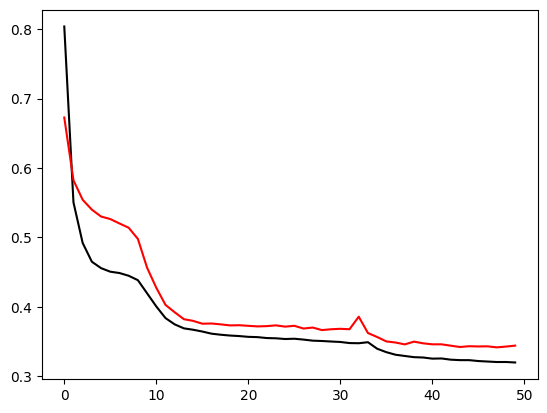

In [40]:
# visualize training and validation curves
plt.plot(history.history["mean_squared_error"], c='k')
plt.plot(history.history["val_mean_squared_error"], c='r')
plt.show()

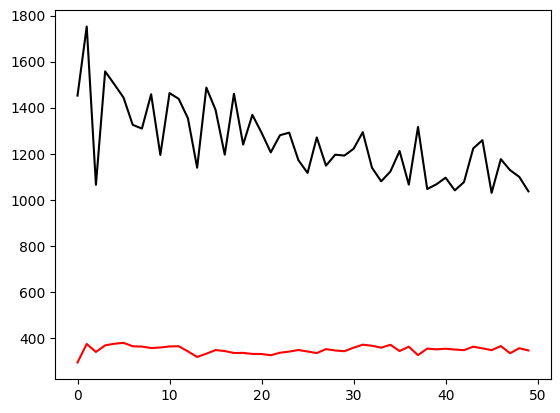

In [41]:
plt.plot(history.history["mean_absolute_percentage_error"], c='k')
plt.plot(history.history["val_mean_absolute_percentage_error"], c='r')
plt.show()

In [42]:
# evaluation mode
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 2ms/step


In [43]:
# check prediction shape matches test data shape
y_pred.shape

(668, 1024)

In [44]:
y_test.shape

(668, 1024)

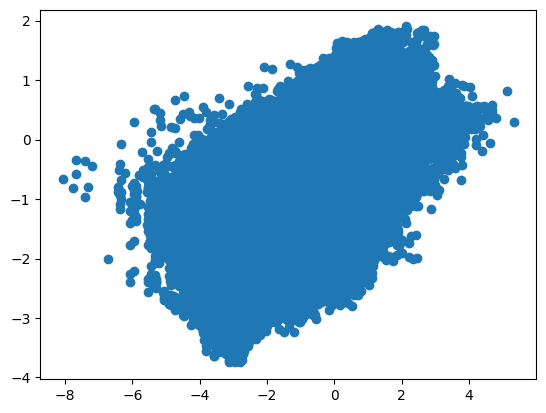

In [45]:
# visualize obs (x-axis) to nn predictions (y-axis)
plt.scatter(y_test, y_pred)
plt.show()

In [46]:
# evaluations (MSE)
mean_squared_error(y_test, y_pred)

0.58079916

In [47]:
# to extract model layers, we can first print out model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                32800     
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
 dense_8 (Dense)             (None, 4)                 36        
                                                                 
 dense_9 (Dense)             (None, 8)                 40        
                                                                 
 dense_10 (Dense)            (None, 32)                288       
                                                                 
 dense_11 (Dense)            (None, 1024)              33792     
                                                                 
Total params: 67220 (262.58 KB)
Trainable params: 6722

In [48]:
# model layers are contained as a list
model.layers

In [49]:
# lets select the first layer
model.layers[0].input

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'input_2')>

In [50]:
# and the bottleneck layer
model.layers[2].output

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense_8')>

In [51]:
# we define the input layer to the ANN and the output of the bottleneck layer
bottleneck = keras.backend.function([model.layers[0].input],[model.layers[2].output])

In [52]:
# input test data into the bottleneck function
bottleneck_output = bottleneck(X_test)

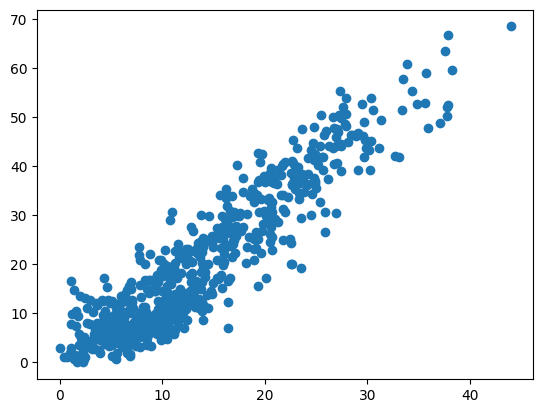

In [53]:
# we can visualize what these two nodes in the bottleneck output
plt.scatter(bottleneck_output[0][:,0],bottleneck_output[0][:,1])
plt.show()

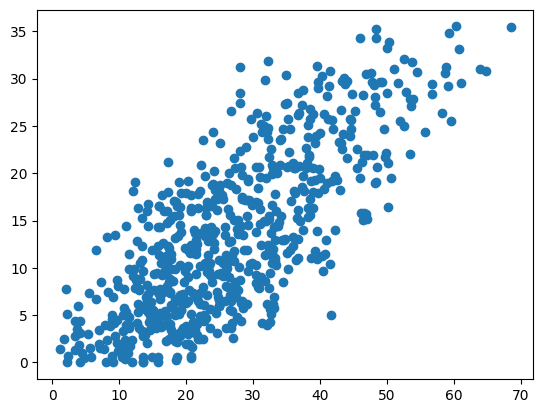

In [54]:
# we can visualize what these two nodes in the bottleneck output
plt.scatter(bottleneck_output[0][:,2],bottleneck_output[0][:,3])
plt.show()

In [55]:
# saving model
model.save('autoencodersample.keras')

In [56]:
# loading model
model2 = keras.models.load_model('autoencodersample.keras')

In [57]:
# inference with loaded model
ypred2 = model2.predict(X_test)

21/21 [==============================] - 0s 2ms/step


We can use autoencoders for the task of anomaly detection. For anomaly detection, we would note instances where reconstruction error for an image is higher, indicating that the sample was likely not similar to those in the training set distribution.

The prediction loss threshold for 2% of outliers is 0.97


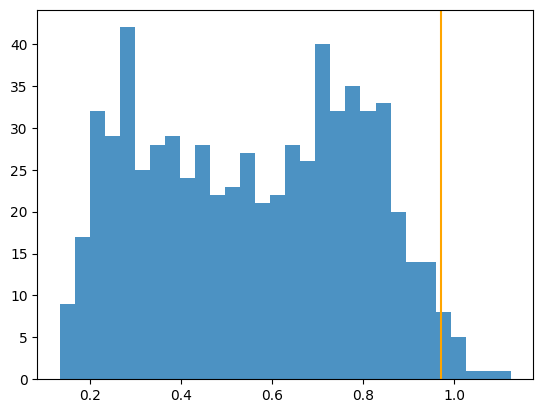

In [58]:
# for get the mean absolute error between actual and reconstruction/prediction
prediction_loss = keras.losses.mae(ypred2, X_test)

# for check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)

print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')
# for visualize the threshold
plt.hist(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')
plt.show()

The prediction loss threshold for 2% of outliers is 18.60


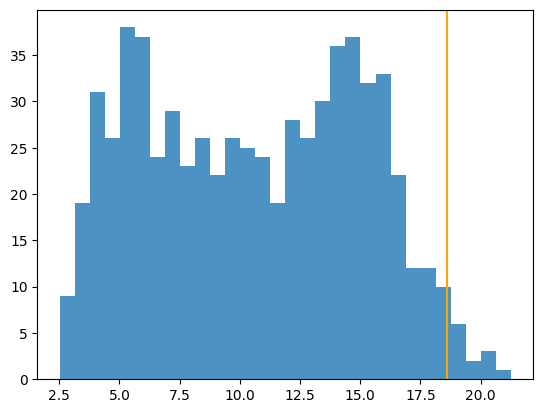

In [59]:
# same as above but for inverse transformed data
# for get the mean absolute error between actual and reconstruction/prediction
prediction_loss = keras.losses.mae(
    scaler.inverse_transform(ypred2),
    scaler.inverse_transform(X_test)
    )

# for check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)

print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')
# for visualize the threshold
plt.hist(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')
plt.show()

## CNN Autoencoder

In [60]:
def z_score(da):
    """
    Compute z-score for training data.
    Normalizing data for ML model training.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.mean(da)) / np.std(da)

def z_score_testing(da, testdata):
    """
    Compute z-score for testing data.
    Args:
        da (array): Array of training variable.
    """
    return (testdata - np.mean(da)) / np.std(da)

In [61]:
# reshape data to be samples, features
features_data = ds['dbz_grid'].values
print(features_data.shape)

(2224, 32, 32)


In [62]:
X_train, X_test, y_train, y_test = features_data[:1800], features_data[1800:], features_data[:1800], features_data[1800:]

In [63]:
X_test = z_score_testing(X_train, X_test) # input
y_test = z_score_testing(y_train, y_test) # label

X_train = z_score(X_train) # input
y_train = z_score(y_train) # label

In [64]:
# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1800, 32, 32) (424, 32, 32) (1800, 32, 32) (424, 32, 32)


In [65]:
model = keras.Sequential()

# input
model.add(keras.Input(shape=(32, 32, 1)))  # 32x32 images

# encoder
# hidden layers
model.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(8, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(4, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

# decoder
model.add(layers.Conv2D(4, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

model.add(layers.Conv2D(8, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

model.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

# Finally, we add last layer
model.add(layers.Conv2D(1, (3, 3), activation='linear', padding='same'))

# print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 4)           292       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 4)          

In [66]:
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

BATCH_SIZE = 32
EPOCHS = 10

In [67]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
51/51 [==============================] - 5s 51ms/step - loss: 0.6572 - mean_squared_error: 0.6572 - root_mean_squared_error: 0.8107 - val_loss: 0.5431 - val_mean_squared_error: 0.5431 - val_root_mean_squared_error: 0.7370
Epoch 2/10
51/51 [==============================] - 2s 46ms/step - loss: 0.3308 - mean_squared_error: 0.3308 - root_mean_squared_error: 0.5752 - val_loss: 0.3983 - val_mean_squared_error: 0.3983 - val_root_mean_squared_error: 0.6311
Epoch 3/10
51/51 [==============================] - 2s 46ms/step - loss: 0.2610 - mean_squared_error: 0.2610 - root_mean_squared_error: 0.5109 - val_loss: 0.3565 - val_mean_squared_error: 0.3565 - val_root_mean_squared_error: 0.5971
Epoch 4/10
51/51 [==============================] - 4s 69ms/step - loss: 0.2315 - mean_squared_error: 0.2315 - root_mean_squared_error: 0.4811 - val_loss: 0.3303 - val_mean_squared_error: 0.3303 - val_root_mean_squared_error: 0.5747
Epoch 5/10
51/51 [==============================] - 2s 44ms/step - l

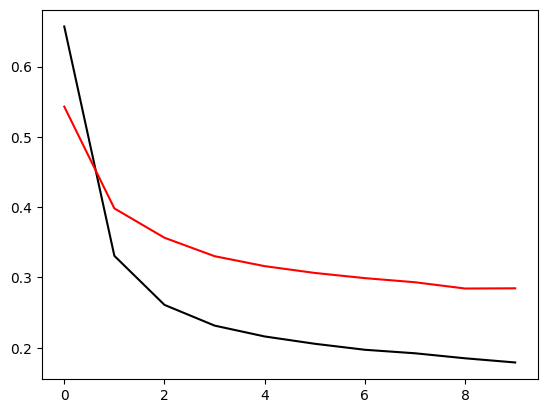

In [68]:
plt.plot(history.history["mean_squared_error"], c='k')
plt.plot(history.history["val_mean_squared_error"], c='r')
plt.show()

In [69]:
# saving model
model.save('autoencodercnn.keras')

# loading model
model2 = keras.models.load_model('autoencodercnn.keras')

In [70]:
# inference with loaded model
ypred2 = model2.predict(X_test)

14/14 [==============================] - 0s 12ms/step


In [71]:
print(X_test.shape, ypred2[:,:,:,0].shape)

(424, 32, 32) (424, 32, 32)


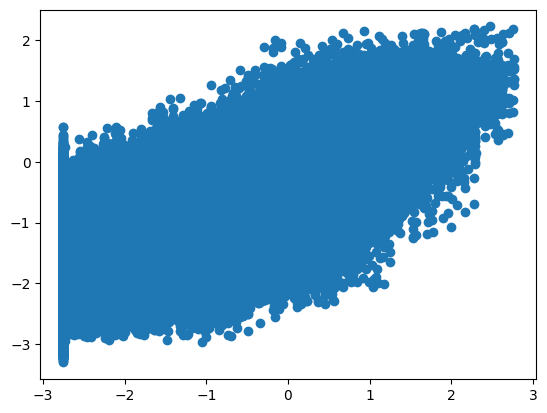

In [72]:
# evaluations
plt.scatter(np.ndarray.flatten(y_test), np.ndarray.flatten(ypred2[:,:,:,0]))
plt.show()

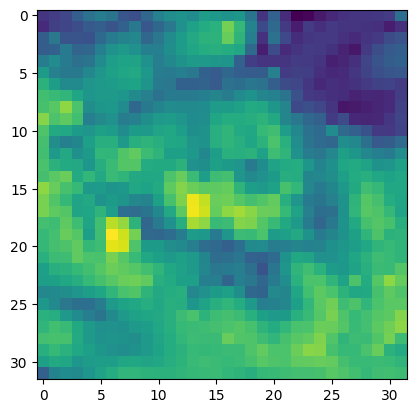

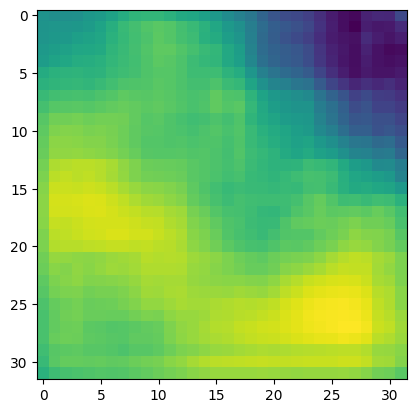

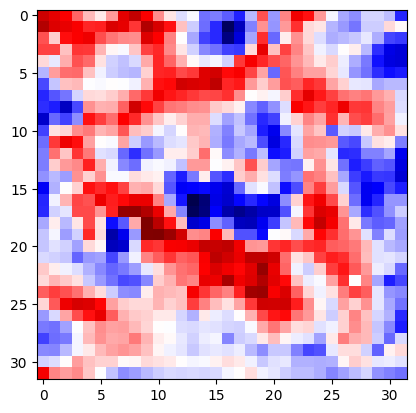

In [75]:
# evaluations
sample_indx = 10

plt.imshow(y_test[sample_indx,:,:], vmin=-1, vmax=1)
plt.show()

plt.imshow(ypred2[sample_indx,:,:,0], vmin=-1, vmax=1)
plt.show()

plt.imshow(ypred2[sample_indx,:,:,0] - y_test[sample_indx,:,:], cmap='seismic')
plt.show()

In [76]:
# evaluations (MSE)
mean_squared_error(np.ndarray.flatten(y_test), np.ndarray.flatten(ypred2[:,:,:,0]))

0.37860158

## CNN Autoencoder Noise Removal

In [77]:
def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

In [78]:
# reshape data to be samples, features
features_data = ds['dbz_grid'].values
print(features_data.shape)

X_train, X_test, y_train, y_test = features_data[:1800], features_data[1800:], features_data[:1800], features_data[1800:]

X_test = z_score_testing(X_train, X_test) # input
y_test = z_score_testing(y_train, y_test) # label

X_train = z_score(X_train) # input
y_train = z_score(y_train) # label

# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2224, 32, 32)
(1800, 32, 32) (424, 32, 32) (1800, 32, 32) (424, 32, 32)


In [79]:
# Create a copy of the data with added noise
noisy_train_data = noise(X_train)
noisy_test_data = noise(X_test)

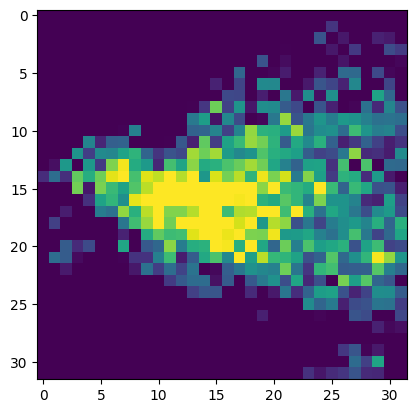

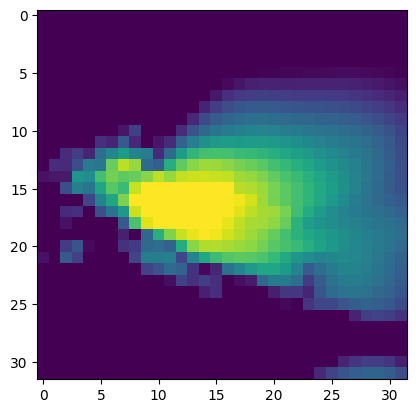

In [80]:
plt.imshow(noisy_train_data[0,:,:], vmin=-1, vmax=1)
plt.show()

plt.imshow(X_train[0,:,:], vmin=-1, vmax=1)
plt.show()

In [85]:
model_transfer = keras.models.load_model('autoencodercnn.keras')

In [87]:
history = model_transfer.fit(
    x=noisy_train_data,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
51/51 [==============================] - 7s 61ms/step - loss: 0.1805 - mean_squared_error: 0.1805 - root_mean_squared_error: 0.4249 - val_loss: 0.2740 - val_mean_squared_error: 0.2740 - val_root_mean_squared_error: 0.5235
Epoch 2/10
51/51 [==============================] - 2s 42ms/step - loss: 0.1737 - mean_squared_error: 0.1737 - root_mean_squared_error: 0.4168 - val_loss: 0.2674 - val_mean_squared_error: 0.2674 - val_root_mean_squared_error: 0.5171
Epoch 3/10
51/51 [==============================] - 2s 42ms/step - loss: 0.1685 - mean_squared_error: 0.1685 - root_mean_squared_error: 0.4105 - val_loss: 0.2619 - val_mean_squared_error: 0.2619 - val_root_mean_squared_error: 0.5118
Epoch 4/10
51/51 [==============================] - 2s 45ms/step - loss: 0.1649 - mean_squared_error: 0.1649 - root_mean_squared_error: 0.4061 - val_loss: 0.2554 - val_mean_squared_error: 0.2554 - val_root_mean_squared_error: 0.5053
Epoch 5/10
51/51 [==============================] - 3s 67ms/step - l

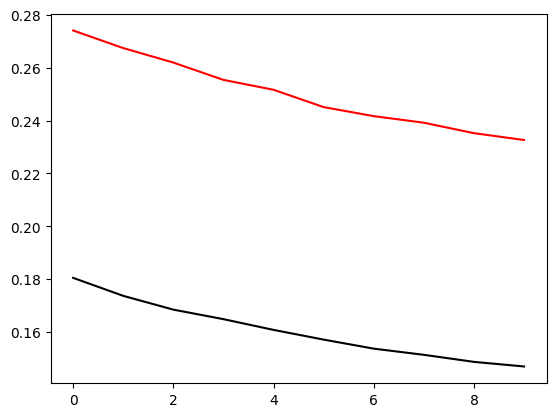

In [88]:
plt.plot(history.history["mean_squared_error"], c='k')
plt.plot(history.history["val_mean_squared_error"], c='r')
plt.show()

In [89]:
# inference with model
ypred = model.predict(noisy_test_data)

14/14 [==============================] - 0s 21ms/step


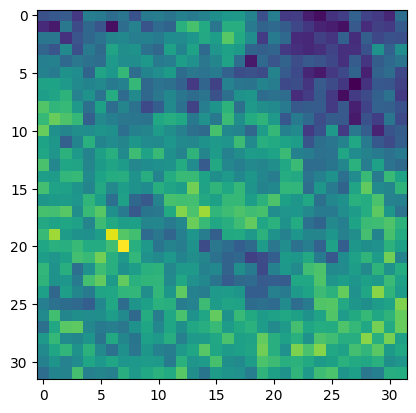

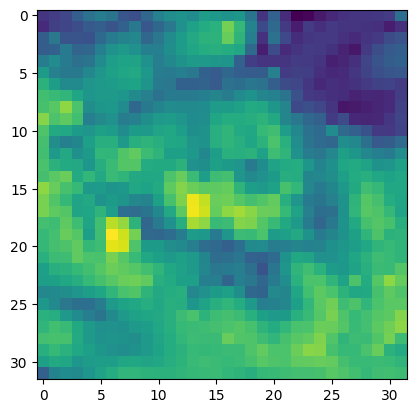

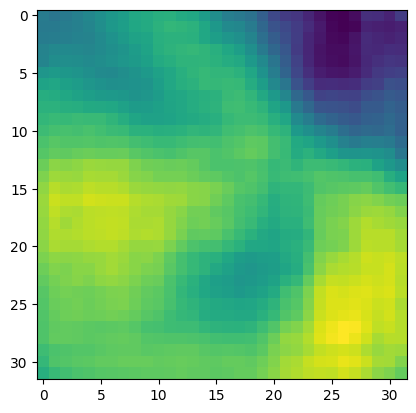

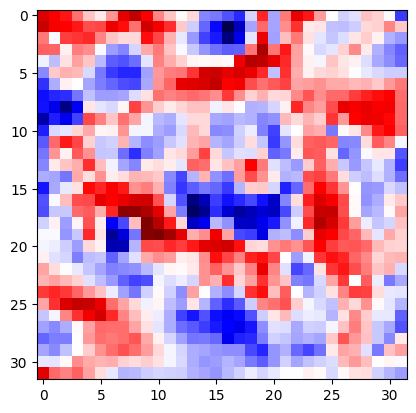

In [90]:
# evaluations
sample_indx = 10

plt.imshow(noisy_test_data[sample_indx, :, :])
plt.show()

plt.imshow(y_test[sample_indx,:,:])
plt.show()

plt.imshow(ypred[sample_indx,:,:,0])
plt.show()

plt.imshow(ypred[sample_indx,:,:,0] - y_test[sample_indx,:,:], cmap='seismic')
plt.show()